In [1]:
import torch
import torch.nn.functional as F
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution, NoiseTunnel
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
gadf_img_path_lable1 = [
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/val/data_22_7/sample1_segment5_label1.jpeg",
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/val/data_22_13/sample1_segment12_label1.jpeg",
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/test/data_32_12/sample1_segment2_label1.jpeg",
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/test/data_32_12/sample1_segment101_label1.jpeg",
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/val/data_22_13/sample1_segment14_label1.jpeg"
]
gadf_img_path_lable0 = [
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/test/data_0_4/sample1_segment144_label0.jpeg",
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/test/data_0_8/sample1_segment7_label0.jpeg",
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/test/data_0_8/sample1_segment9_label0.jpeg",
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/test/data_15_10/sample1_segment6_label0.jpeg",
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/test/data_32_26/sample1_segment4_label0.jpeg",
]
gasf_img_path_lable1 = [
    "/home/prasad/Desktop/datas2/GASFC_train_test_val/val/data_22_7/sample1_segment5_label1.jpeg",
    "/home/prasad/Desktop/datas2/GASFC_train_test_val/val/data_22_13/sample1_segment12_label1.jpeg",
    "/home/prasad/Desktop/datas2/GASFC_train_test_val/test/data_32_12/sample1_segment2_label1.jpeg",
    "/home/prasad/Desktop/datas2/GASFC_train_test_val/test/data_32_12/sample1_segment101_label1.jpeg",
    "/home/prasad/Desktop/datas2/GASFC_train_test_val/val/data_22_13/sample1_segment14_label1.jpeg",
]
gasf_img_path_lable0 = [
    "/home/prasad/Desktop/datas2/GASFC_train_test_val/test/data_0_4/sample1_segment144_label0.jpeg",
    "/home/prasad/Desktop/datas2/GASFC_train_test_val/test/data_0_8/sample1_segment7_label0.jpeg",
    "/home/prasad/Desktop/datas2/GASFC_train_test_val/test/data_0_8/sample1_segment9_label0.jpeg",
    "/home/prasad/Desktop/datas2/GASFC_train_test_val/test/data_15_10/sample1_segment6_label0.jpeg",
    "/home/prasad/Desktop/datas2/GASFC_train_test_val/test/data_32_26/sample1_segment4_label0.jpeg",
]

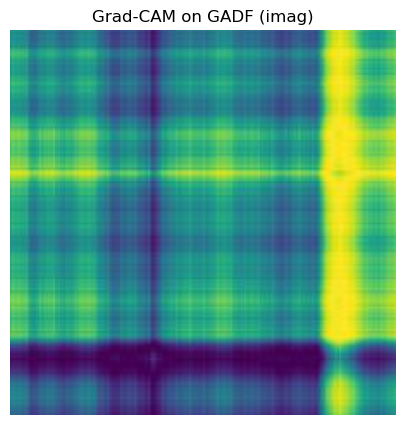

Using device: cuda
Model output: tensor([[-15.3254]], device='cuda:0', grad_fn=<AddmmBackward0>)
Raw prediction: tensor([2.2094e-07], device='cuda:0', grad_fn=<ViewBackward0>)
Prediction: 0.0


In [3]:
from data.dataloader import load_config
from models.custom_resnet import resnet18
from torchvision import models, transforms

gadf_image = Image.open(
    "/home/prasad/Desktop/datas2/GADFC_train_test_val/test/data_32_26/sample1_segment4_label0.jpeg"
).convert("RGB")
test_img_data = np.asarray(gadf_image)


# Show with matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(test_img_data)
plt.title("Grad-CAM on GADF (imag)")
plt.axis("off")
plt.show()
transforms_gadf = transforms.Compose(
    [
        transforms.Normalize(
            mean=[0.19756491, 0.5550784, 0.50753045],
            std=[0.08108524, 0.10870767, 0.05927933],
        ),
    ]
)
transforms_gasf = transforms.Compose(
    [
        transforms.Normalize(
            mean=[0.25332475, 0.17397244, 0.43626496],
            std=[0.03306787, 0.08601908, 0.04909801],
        ),
    ]
)
transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)
gadf = transforms(gadf_image)

transformed_gadf_image = transforms_gadf(gadf)

config = load_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

# Load the real-valued model for GADF
model = resnet18()
# Assuming you have a saved model for real-valued ResNet on GADF images
state = torch.load(
    "saved_models/Resnet18_GADF/Resnet18_GADF_model_epoch_22.pth",  # Update this path to your real-valued model
    map_location=device,
)
new_state = {k[7:] if k.startswith("module.") else k: v for k, v in state.items()}
model.load_state_dict(new_state, strict=True)
model = model.to(device)
model = model.eval()

# Use only the GADF image as input (not complex)
input_image = transformed_gadf_image.unsqueeze(0).to(device)

# Forward pass to get the model output
output = model(input_image)
print(f"Model output: {output}")
pred = torch.sigmoid(output).view(-1)
print(f"Raw prediction: {pred}")
pred = (pred > 0.5).float()  # Convert to binary prediction
print(f"Prediction: {pred.item()}")

if isinstance(model, torch.nn.DataParallel):
    model = model.module

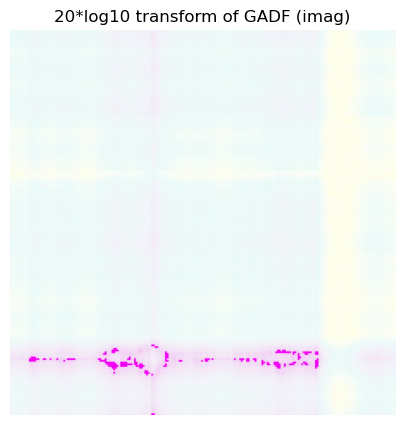

In [4]:
# Apply 20*log10 transformation to both images
epsilon = 1e-10  # Small constant to avoid log(0)


# Transform GADF data
log_img_data = 20 * np.log10(test_img_data.astype(float) + epsilon)


# Normalize for better visualization
def normalize_for_display(img):
    min_val = np.min(img)
    max_val = np.max(img)
    return (img - min_val) / (max_val - min_val)


norm_log_img = normalize_for_display(log_img_data)

# Show results with matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(norm_log_img)
plt.title("20*log10 transform of GADF (imag)")
plt.axis("off")
plt.show()

In [5]:
# Prepare input for Captum (no need to concatenate real and imaginary parts)
x_captum = input_image.clone()
x_captum.requires_grad_()

tensor([[[[-0.7921, -0.5987, -0.5503,  ...,  0.1268,  0.3202,  0.6588],
          [-1.0823, -0.8889, -0.9372,  ..., -0.3085, -0.1151,  0.1751],
          [-1.0340, -0.7921, -0.8405,  ..., -0.3085, -0.1151,  0.1268],
          ...,
          [-0.2601, -0.1634, -0.1151,  ..., -0.7438, -0.6954, -0.5987],
          [-0.3085, -0.1151, -0.0667,  ..., -0.6954, -0.6471, -0.6471],
          [-0.2601, -0.0667, -0.1151,  ..., -0.8889, -0.7921, -0.7438]],

         [[ 0.0886,  0.2689,  0.3050,  ...,  1.4955,  1.6758,  1.9284],
          [-0.1640,  0.0525,  0.1246,  ...,  1.1347,  1.3151,  1.6037],
          [-0.0557,  0.1246,  0.1607,  ...,  1.0986,  1.2790,  1.5676],
          ...,
          [-1.3183, -1.1380, -1.1019,  ...,  0.0886,  0.1968,  0.3050],
          [-1.4266, -1.2823, -1.2462,  ..., -0.0557,  0.0886,  0.1968],
          [-1.4987, -1.3544, -1.2823,  ..., -0.2000, -0.0918,  0.0164]],

         [[ 0.3691,  0.6999,  0.8984,  ..., -1.2186, -1.2847, -0.9540],
          [ 0.1045,  0.4353,  

## Feature Attribution with Integrated Gradients

**Feature attribution** attributes a particular output to features of the input. It uses a specific input - here, our test image - to generate a map of the relative importance of each input feature to a particular output feature.

[**Integrated Gradients**](https://captum.ai/api/integrated_gradients.html) is one of the feature attribution algorithms available in Captum. Integrated Gradients assigns an importance score to each input feature by approximating the integral of the gradients of the model's output with respect to the inputs.

In our case, we're going to be taking a specific element of the output vector - that is, the one indicating the model's confidence in its chosen category - and use Integrated Gradients to understand what parts of the input image contributed to this output.

Once we have the importance map from Integrated Gradients, we'll use the visualization tools in Captum to give a helpful representation of the importance map. Captum's `visualize_image_attr()` function provides a variety of options for customizing display of your attribution data. Here, we pass in a custom Matplotlib color map.

Running the cell with the `integrated_gradients.attribute()` call will usually take a minute or two.

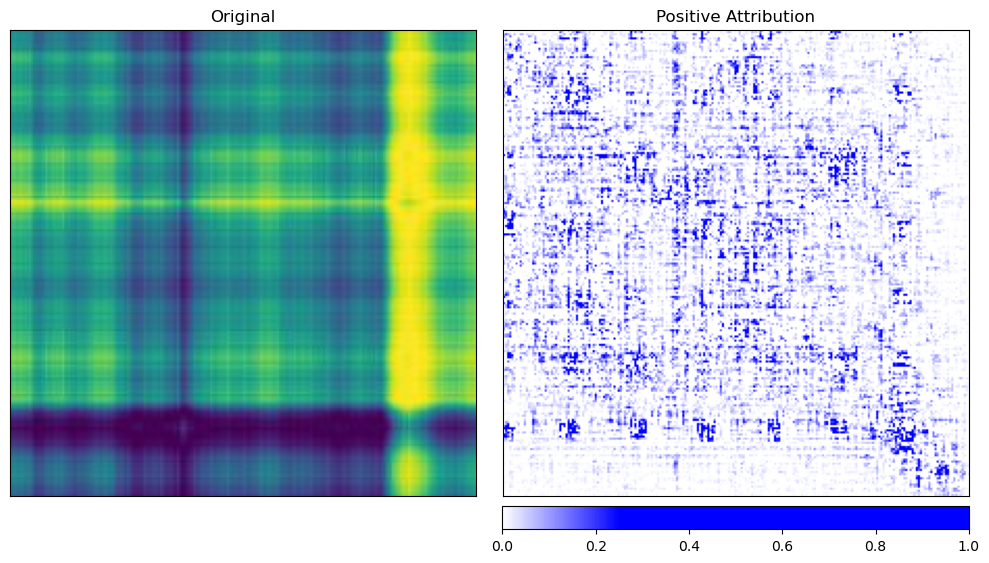

In [6]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)
attributions = ig.attribute(x_captum, target=0, n_steps=10)

default_cmap = LinearSegmentedColormap.from_list(
    "custom blue", [(0, "#ffffff"), (0.25, "#0000ff"), (1, "#0000ff")], N=256
)
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(gadf.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    cmap=default_cmap,
    titles=["Original", "Positive Attribution"],
    fig_size=(10, 6),
)

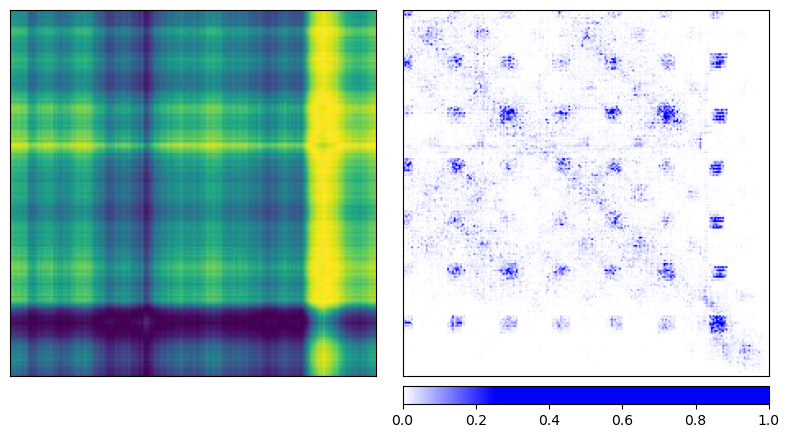

In [7]:
noise_tunnel = NoiseTunnel(ig)

attributions_ig_nt = noise_tunnel.attribute(
    x_captum, nt_samples=3, nt_type="smoothgrad_sq", target=0
)
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(gadf.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map"],
    ["all", "positive"],
    cmap=default_cmap,
    show_colorbar=True,
)

## Feature Attribution with Occlusion

Gradient-based attribution methods help to understand the model in terms of directly computing out the output changes with respect to the input. *Perturbation-based attribution* methods approach this more directly, by introducing changes to the output to measure the effect on the output. [**Occlusion**](https://captum.ai/api/occlusion.html) is one such method. It involves replacing sections of the input image, and examining the effect on the output signal.

Below, we set up Occlusion attribution. Similarly to configuring a convolutional neural network, you can specify the size of the target region, and a stride length to determine the spacing of individual measurements. We'll visualize the output of our Occlusion attribution with `visualize_image_attr_multiple()`, showing heat maps of both positive and negative attribution by region, and by masking the original image with the positive attribution regions. The masking gives a very instructive view of what regions of our cat photo the model found to be most "cat-like".

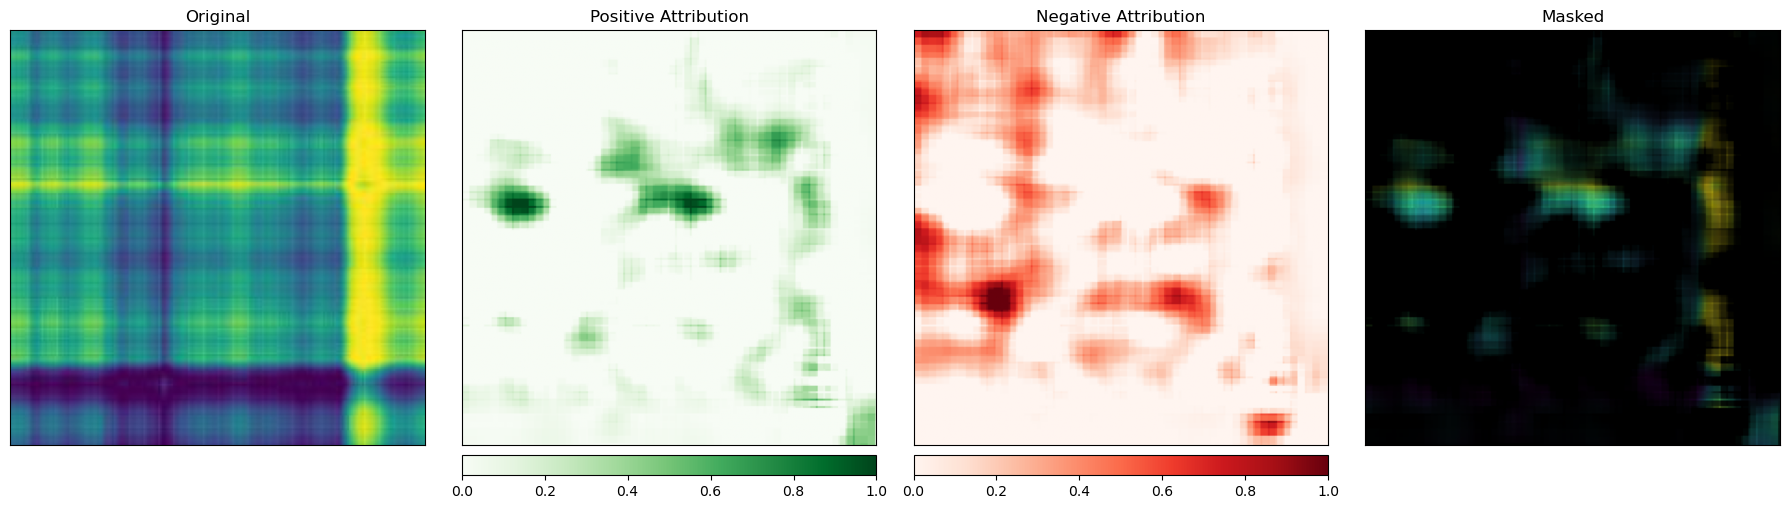

In [8]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(
    x_captum,
    target=0,
    strides=(3, 4, 4),
    sliding_window_shapes=(3, 15, 15),
    baselines=0,
)

_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(gadf.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map", "heat_map", "masked_image"],
    ["all", "positive", "negative", "positive"],
    show_colorbar=True,
    titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
    fig_size=(18, 6),
)

### Grad Cam

In [9]:
import torch
import torch.nn as nn


class SimpleResNetCAM(nn.Module):
    def __init__(self, config, checkpoint_path, device):
        super().__init__()
        self.model = resnet18(config)
        state = torch.load(checkpoint_path, map_location=device)
        state = {k[7:] if k.startswith("module.") else k: v for k, v in state.items()}
        self.model.load_state_dict(state, strict=True)
        self.model.to(device).eval()

        # Register hooks at last conv layer: layer4[-1].conv2
        self.gradients = None
        self.activations = None

        def forward_hook(module, inp, out):
            self.activations = out  # shape: [B, C, H, W]

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]  # shape: [B, C, H, W]

        target_layer = self.model.layer4[-1].conv2
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def forward(self, x):
        return self.model(x)

    def get_activations(self):
        return self.activations

    def get_activations_gradient(self):
        return self.gradients

Creating ResNet-18 with 3 channels and 1 classes
Prediction: False
Gradients: torch.Size([1, 512, 7, 7]) torch.float32
Activations: torch.Size([1, 512, 7, 7]) torch.float32


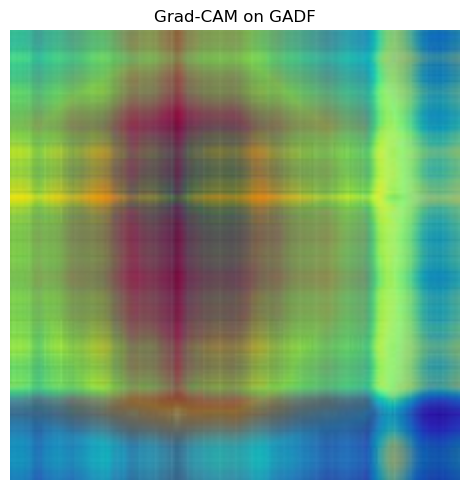

In [10]:
from data.dataloader import load_config
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2


config = load_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = "saved_models/Resnet18_GADF/Resnet18_GADF_model_epoch_22.pth"

# === 3) Build the CAM wrapper ===
cam_model = SimpleResNetCAM(config, checkpoint, device)

# === 4) Prepare input ===
# If your image is complex, use only real part (e.g., GADF image)
real_img = gadf.unsqueeze(0).to(device)  # [1, 3, H, W]
real_img.requires_grad_()

# === 5) Forward + backward ===
cam_model.zero_grad()
logit = cam_model(real_img)
logit[0, 0].backward()  # binary classification

pred = torch.sigmoid(logit) > 0.5
print("Prediction:", pred.item())

# === 6) Retrieve gradients and activations ===
grads = cam_model.get_activations_gradient()  # [1, C, H, W]
acts = cam_model.get_activations()  # [1, C, H, W]

print("Gradients:", grads.shape, grads.dtype)
print("Activations:", acts.shape, acts.dtype)


def compute_gradcam_heatmap(activations, gradients):
    """
    activations: Tensor of shape [1, C, h, w]
    gradients:   Tensor of shape [1, C, h, w]
    returns:     heatmap np.ndarray of shape [h, w] in [0,1]
    """
    # 1) Pool gradients across spatial dims → [C]
    pooled = gradients.mean(dim=[0, 2, 3])  # shape [C]

    # 2) Weight channels
    weighted = activations.clone()
    for i in range(weighted.shape[1]):
        weighted[:, i, :, :] *= pooled[i]

    # 3) Average across channels → [1, h, w]
    heatmap = weighted.mean(
        dim=1, keepdim=True
    )  # [1,1,h,w] if keepdim, but here [1,h,w]
    heatmap = F.relu(heatmap)  # only positives
    heatmap = heatmap.squeeze().cpu().detach().numpy()

    # 4) Normalize to [0,1]
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() > 0:
        heatmap /= heatmap.max()
    return heatmap


# Compute two heatmaps
heatmap = compute_gradcam_heatmap(acts, grads)


# Resize & overlay function
def overlay_on_original(original_image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    original_complex:  Tensor [1,3,H,W] complex
    heatmap:           np.ndarray [h,w] normalized [0,1]
    returns:           BGR overlay np.ndarray [H,W,3]
    """
    bg = original_image.cpu().numpy().transpose(1, 2, 0)  # [H,W,3] in RGB
    bg = cv2.cvtColor(bg, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

    # Normalize to [0,255]
    bg = (255 * (bg - bg.min()) / (bg.max() - bg.min() + 1e-8)).astype(np.uint8)

    H, W = bg.shape[:2]
    hm_resized = cv2.resize(heatmap, (W, H))
    hm_uint8 = np.uint8(255 * hm_resized)
    hm_color = cv2.applyColorMap(hm_uint8, colormap)
    overlay = cv2.addWeighted(hm_color, alpha, bg, 1 - alpha, 0)
    return overlay


# Prepare your original GAF images:
# complex_img: [1,3,H,W] complex (GASF in real, GADF in imag)
overlay_imag = overlay_on_original(gadf, heatmap)

# Show with matplotlib (convert BGR to RGB)
plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 2)
# plt.imshow(heatmap, cmap="jet")
# plt.title("Heatmap")
# plt.axis("off")
# plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(overlay_imag, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM on GADF")
plt.axis("off")
plt.tight_layout()
plt.show()